## Răzvan-Gabriel Olariu - DS - 411 - Anomaly Detection - Laboratory 3

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from scipy.io import loadmat
from pyod.models.iforest import IForest
from pyod.models.loda import LODA
from pyod.models.dif import DIF
from pyod.utils.utility import standardizer

import warnings
warnings.filterwarnings("ignore")

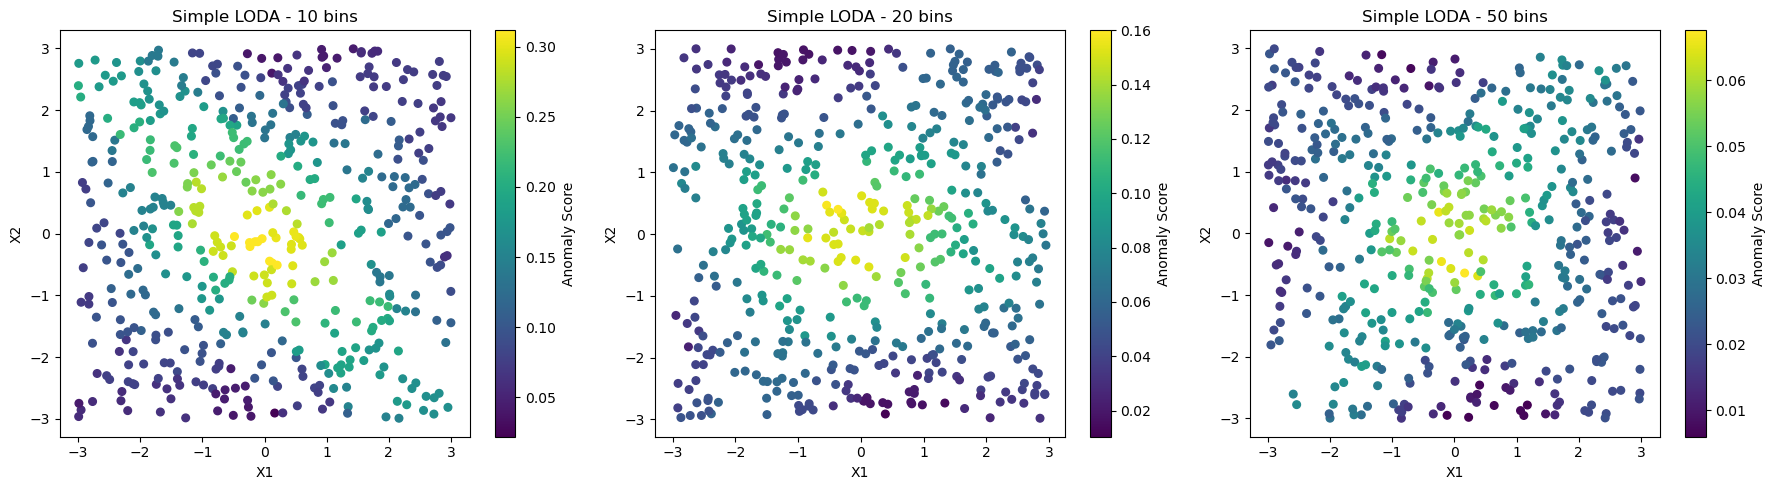

In [9]:
# Exercise 1 - Simple LODA variant

X_train, _ = make_blobs(n_samples=500, n_features=2, centers=[[0, 0]], cluster_std=1.0, random_state=42)

n_projections = 5
bin_values = [10, 20, 50]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, n_bins in enumerate(bin_values):
    projections = []
    histograms = []
    
    for i in range(n_projections):
        proj = np.random.multivariate_normal([0, 0], np.eye(2))
        proj = proj / np.linalg.norm(proj)
        projections.append(proj)
        
        projected_values = X_train @ proj
        counts, bins = np.histogram(projected_values, bins=n_bins, range=(projected_values.min()-1, projected_values.max()+1))
        probs = counts / counts.sum()
        histograms.append((bins, probs))
    
    X_test = np.random.uniform(-3, 3, size=(500, 2))
    
    scores = []
    for x in X_test:
        probs_list = []
        for proj, (bins, probs) in zip(projections, histograms):
            val = x @ proj
            bin_idx = np.digitize(val, bins) - 1
            bin_idx = np.clip(bin_idx, 0, len(probs)-1)
            probs_list.append(probs[bin_idx])
        scores.append(np.mean(probs_list))
    
    scores = np.array(scores)
    
    sc = axes[idx].scatter(X_test[:, 0], X_test[:, 1], c=scores, cmap='viridis', s=30)
    axes[idx].set_title(f'Simple LODA - {n_bins} bins')
    axes[idx].set_xlabel('X1')
    axes[idx].set_ylabel('X2')
    plt.colorbar(sc, ax=axes[idx], label='Anomaly Score')

plt.tight_layout()
plt.show()

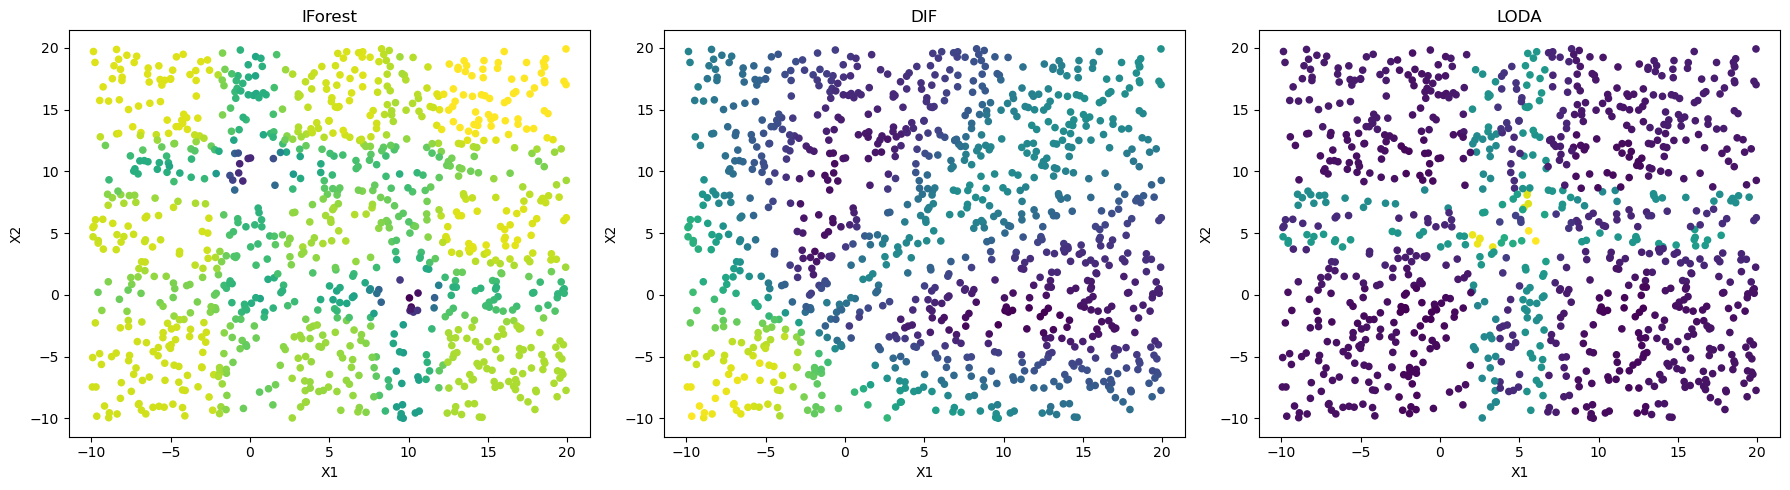

In [10]:
# Exercise 2 - IForest artifacts in 2D

X_train, _ = make_blobs(n_samples=1000, n_features=2, centers=[[10, 0], [0, 10]], cluster_std=1, random_state=42)

iforest = IForest(contamination=0.02)
iforest.fit(X_train)

X_test = np.random.uniform(-10, 20, size=(1000, 2))

scores_if = iforest.decision_function(X_test)
scores_dif = DIF(contamination=0.02, hidden_neurons=[64, 32]).fit(X_train).decision_function(X_test)
scores_loda = LODA(contamination=0.02).fit(X_train).decision_function(X_test)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(X_test[:, 0], X_test[:, 1], c=scores_if, cmap='viridis', s=20)
axes[0].set_title('IForest')
axes[0].set_xlabel('X1')
axes[0].set_ylabel('X2')

axes[1].scatter(X_test[:, 0], X_test[:, 1], c=scores_dif, cmap='viridis', s=20)
axes[1].set_title('DIF')
axes[1].set_xlabel('X1')
axes[1].set_ylabel('X2')

axes[2].scatter(X_test[:, 0], X_test[:, 1], c=scores_loda, cmap='viridis', s=20)
axes[2].set_title('LODA')
axes[2].set_xlabel('X1')
axes[2].set_ylabel('X2')

plt.tight_layout()
plt.show()

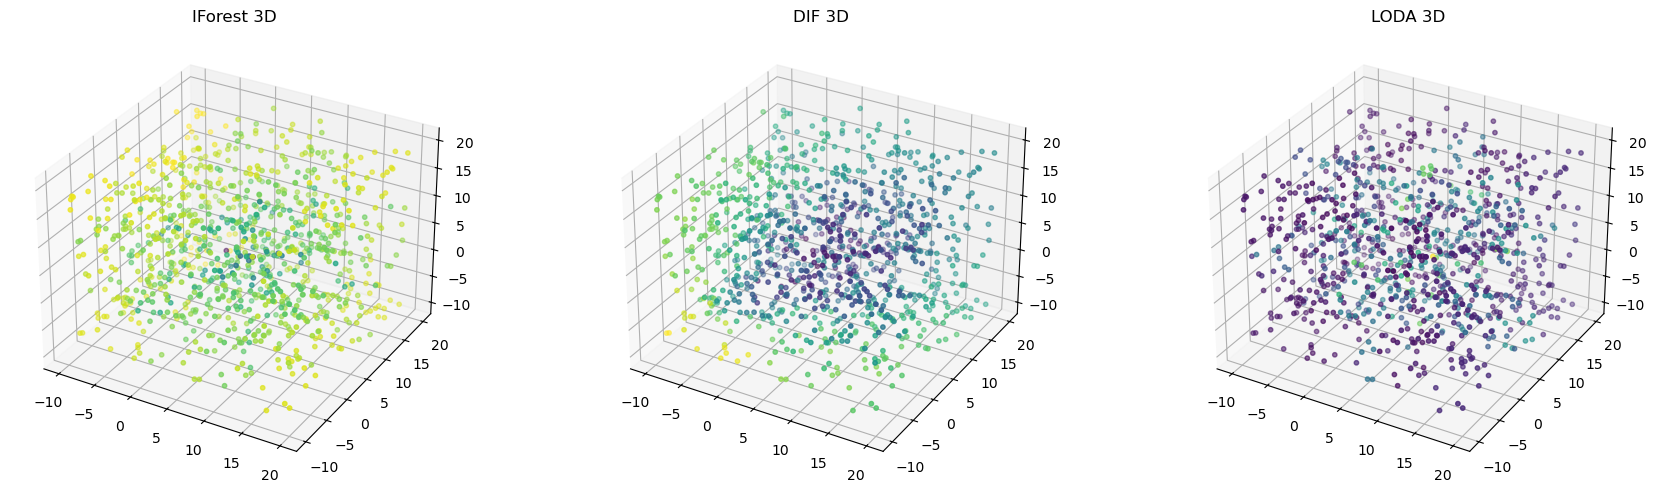

In [11]:
# Exercise 2 - 3D version

X_train_3d, _ = make_blobs(n_samples=1000, n_features=3, centers=[[0, 10, 0], [10, 0, 10]], cluster_std=1, random_state=42)

iforest_3d = IForest(contamination=0.02)
iforest_3d.fit(X_train_3d)

X_test_3d = np.random.uniform(-10, 20, size=(1000, 3))

scores_if_3d = iforest_3d.decision_function(X_test_3d)
scores_dif_3d = DIF(contamination=0.02, hidden_neurons=[64, 32]).fit(X_train_3d).decision_function(X_test_3d)
scores_loda_3d = LODA(contamination=0.02).fit(X_train_3d).decision_function(X_test_3d)

fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X_test_3d[:, 0], X_test_3d[:, 1], X_test_3d[:, 2], c=scores_if_3d, cmap='viridis', s=10)
ax1.set_title('IForest 3D')

ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_test_3d[:, 0], X_test_3d[:, 1], X_test_3d[:, 2], c=scores_dif_3d, cmap='viridis', s=10)
ax2.set_title('DIF 3D')

ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(X_test_3d[:, 0], X_test_3d[:, 1], X_test_3d[:, 2], c=scores_loda_3d, cmap='viridis', s=10)
ax3.set_title('LODA 3D')

plt.tight_layout()
plt.show()

In [ ]:
# Exercise 3 - Shuttle dataset

data = loadmat('shuttle.mat')
X = data['X']
y = data['y'].ravel()

ba_iforest = []
ba_loda = []
ba_dif = []
roc_iforest = []
roc_loda = []
roc_dif = []

for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=i)
    
    X_train, X_test = standardizer(X_train, X_test)
    
    clf_if = IForest(contamination=0.1)
    clf_if.fit(X_train)
    y_pred_if = clf_if.predict(X_test)
    y_score_if = clf_if.decision_function(X_test)
    
    clf_loda = LODA(contamination=0.1)
    clf_loda.fit(X_train)
    y_pred_loda = clf_loda.predict(X_test)
    y_score_loda = clf_loda.decision_function(X_test)
    
    clf_dif = DIF(contamination=0.1, hidden_neurons=[32, 16])
    clf_dif.fit(X_train)
    y_pred_dif = clf_dif.predict(X_test)
    y_score_dif = clf_dif.decision_function(X_test)
    
    ba_iforest.append(balanced_accuracy_score(y_test, y_pred_if))
    ba_loda.append(balanced_accuracy_score(y_test, y_pred_loda))
    ba_dif.append(balanced_accuracy_score(y_test, y_pred_dif))
    
    roc_iforest.append(roc_auc_score(y_test, y_score_if))
    roc_loda.append(roc_auc_score(y_test, y_score_loda))
    roc_dif.append(roc_auc_score(y_test, y_score_dif))

print(f"IForest - BA: {np.mean(ba_iforest):.4f}, ROC AUC: {np.mean(roc_iforest):.4f}")
print(f"LODA - BA: {np.mean(ba_loda):.4f}, ROC AUC: {np.mean(roc_loda):.4f}")
print(f"DIF - BA: {np.mean(ba_dif):.4f}, ROC AUC: {np.mean(roc_dif):.4f}")

# LODa and DIF seem to show poor performance on this dataset, posibly due to suboptimal hyperparameter choices or the nature of the data. Iforest shows relatively better results.

IForest - BA: 0.9768, ROC AUC: 0.9972
LODA - BA: 0.6437, ROC AUC: 0.5578
DIF - BA: 0.5412, ROC AUC: 0.9730
